## Carregamento e Pré-Processamento dos Dados

In [4]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

#Verificando e se você não tiver, vai baixar todos os recursos necessários
def download_nltk_resources():
    resources = {
        'punkt': 'tokenizers/punkt',
        'stopwords': 'corpora/stopwords',
        'wordnet': 'corpora/wordnet',
        'omw-1.4': 'corpora/omw-1.4',
        'punkt_tab': 'tokenizers/punkt_tab'
    }
    
    for resource, path in resources.items():
        try:
            nltk.data.find(path)
            print(f"Recurso {resource} já está instalado")
        except LookupError:
            print(f"Baixando recurso {resource}...")
            nltk.download(resource)

#Executando a função de download
download_nltk_resources()

#Carregando os dados
df = pd.read_csv('dados/Tweets.csv')

#Função de limpeza de textoa
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    #Remoção de URLs, menções e caracteres especiais
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

#Aplicando limpeza acima
df['clean_text'] = df['text'].apply(clean_text)

#Removendo as duplicatas e textos vazios
df = df[df['clean_text'].str.len() > 0].drop_duplicates(subset=['clean_text'])

#Configurando para a lematização
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#Função de pré-processamento 
def preprocess_text(text):
    try:
        tokens = word_tokenize(text)
        return ' '.join(
            lemmatizer.lemmatize(
                lemmatizer.lemmatize(word, pos='v'), pos='n'
            ) for word in tokens 
            if word not in stop_words and len(word) > 2
        )
    except Exception as e:
        print(f"Erro no texto: '{text[:50]}...' - {str(e)}")
        return ""

#Pré-processamento 
tqdm.pandas()
print("\nIniciando pré-processamento...")
df['processed_text'] = df['clean_text'].progress_apply(preprocess_text)

#Removendo as linhas com texto vazio
df = df[df['processed_text'].str.len() > 0]

#Colunas auxiliares
df['text_length'] = df['clean_text'].apply(len)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))

#Verificando os dados
print("\nPré-processamento concluído com sucesso!")
print(f"Tamanho final do dataset: {len(df)}")
print("\nAmostra dos resultados:")
print(df[['text', 'processed_text']].head(3).to_markdown())

Recurso punkt já está instalado
Recurso stopwords já está instalado
Baixando recurso wordnet...
Baixando recurso omw-1.4...
Recurso punkt_tab já está instalado


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Iniciando pré-processamento...


100%|██████████| 14183/14183 [00:01<00:00, 10345.56it/s]


Pré-processamento concluído com sucesso!
Tamanho final do dataset: 14158

Amostra dos resultados:
|    | text                                                                     | processed_text                               |
|---:|:-------------------------------------------------------------------------|:---------------------------------------------|
|  0 | @VirginAmerica What @dhepburn said.                                      | say                                          |
|  1 | @VirginAmerica plus you've added commercials to the experience... tacky. | plus youve add commercial experience tacky   |
|  2 | @VirginAmerica I didn't today... Must mean I need to take another trip!  | didnt today must mean need take another trip |


### Análise Inicial

In [5]:
print(f"Total de tweets após limpeza: {len(df)}")
print(f"Distribuição por companhia aérea:\n{df['airline'].value_counts()}")
print(f"Distribuição de sentimentos:\n{df['airline_sentiment'].value_counts()}")

Total de tweets após limpeza: 14158
Distribuição por companhia aérea:
airline
United            3777
US Airways        2859
American          2549
Southwest         2363
Delta             2116
Virgin America     494
Name: count, dtype: int64
Distribuição de sentimentos:
airline_sentiment
negative    9056
neutral     2920
positive    2182
Name: count, dtype: int64


## Análise Exploratória

#### Volume de Tweets por Dia

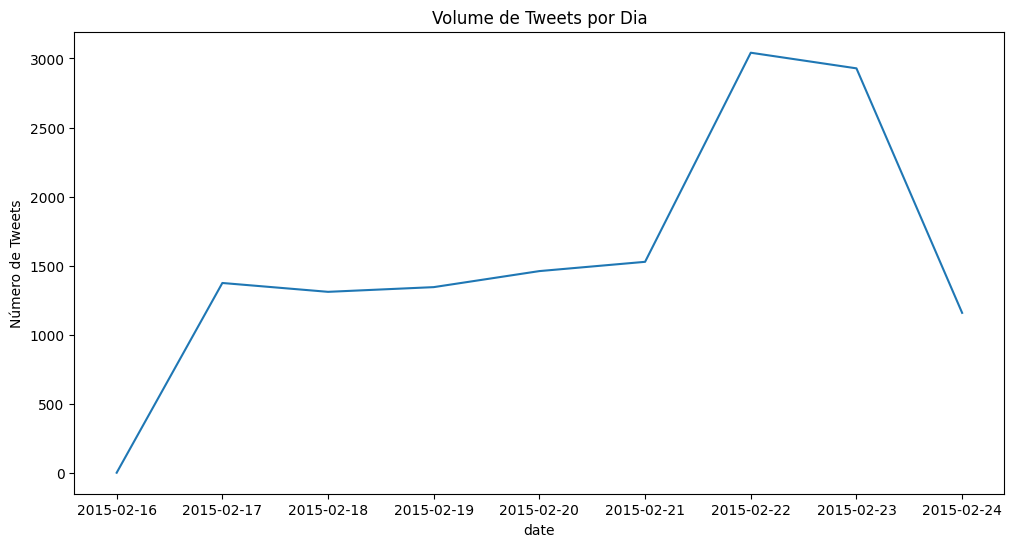

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

#Convertendo  para datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

#Extraindo o dia e a hora
df['date'] = df['tweet_created'].dt.date
df['hour'] = df['tweet_created'].dt.hour

#Gráfico de Volume de Tweets por Dia
plt.figure(figsize=(12, 6))
df.groupby('date').size().plot(kind='line', title='Volume de Tweets por Dia')
plt.ylabel('Número de Tweets')
plt.show()

#### Distribuição de Sentimentos

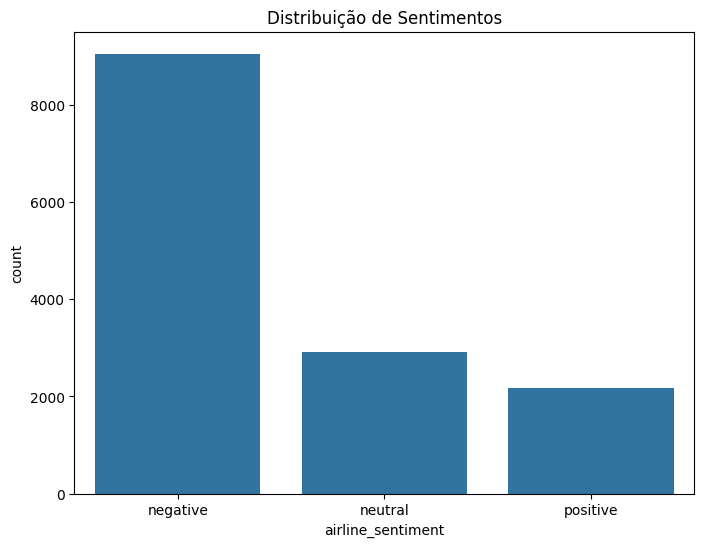

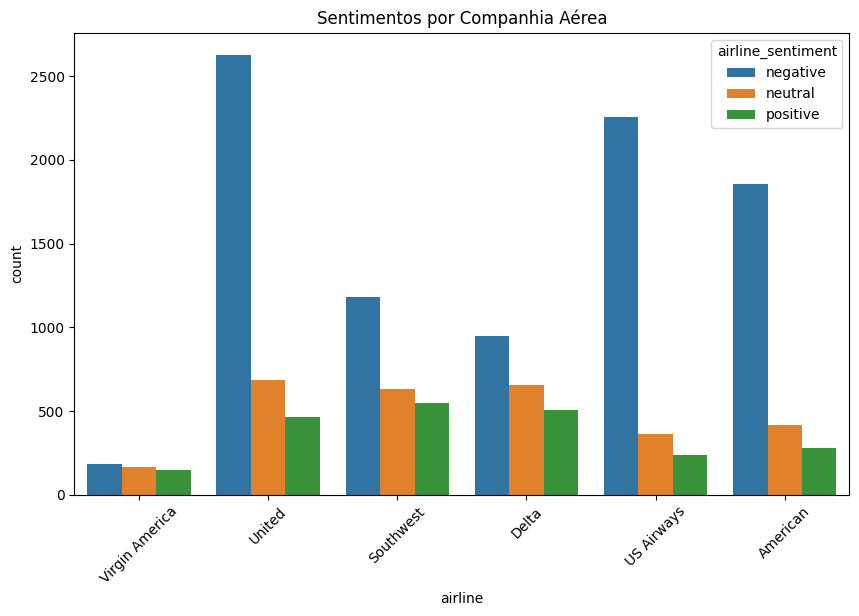

In [7]:
#Distribuição geral
plt.figure(figsize=(8, 6))
sns.countplot(x='airline_sentiment', data=df, order=['negative', 'neutral', 'positive'])
plt.title('Distribuição de Sentimentos')
plt.show()

#Gráfico Por companhia aérea
plt.figure(figsize=(10, 6))
sns.countplot(x='airline', hue='airline_sentiment', data=df, 
              hue_order=['negative', 'neutral', 'positive'])
plt.title('Sentimentos por Companhia Aérea')
plt.xticks(rotation=45)
plt.show()

#### Nuvem de Palavras mais Usadas

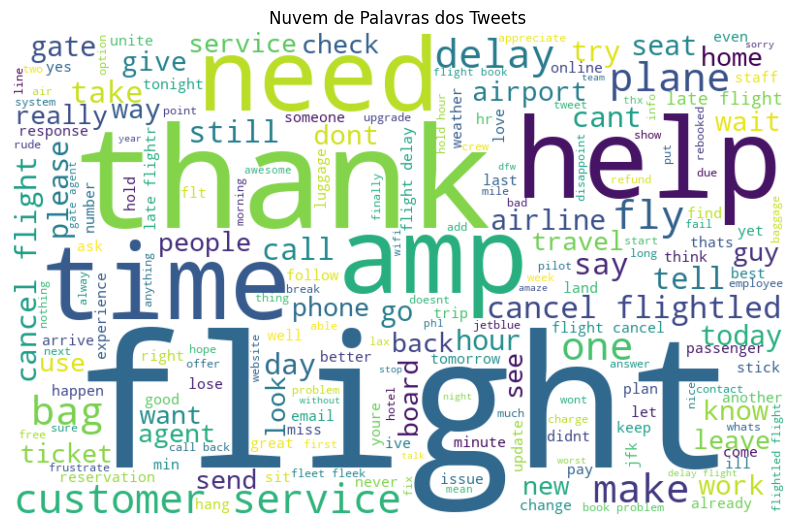

In [8]:
from wordcloud import WordCloud

#Concatenando todos os textos
all_text = ' '.join(df['processed_text'])

#Gerando a nuvem de palavras
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(all_text)

#Criando o gráfico
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Tweets')
plt.show()

#### Sentimentos Negativos

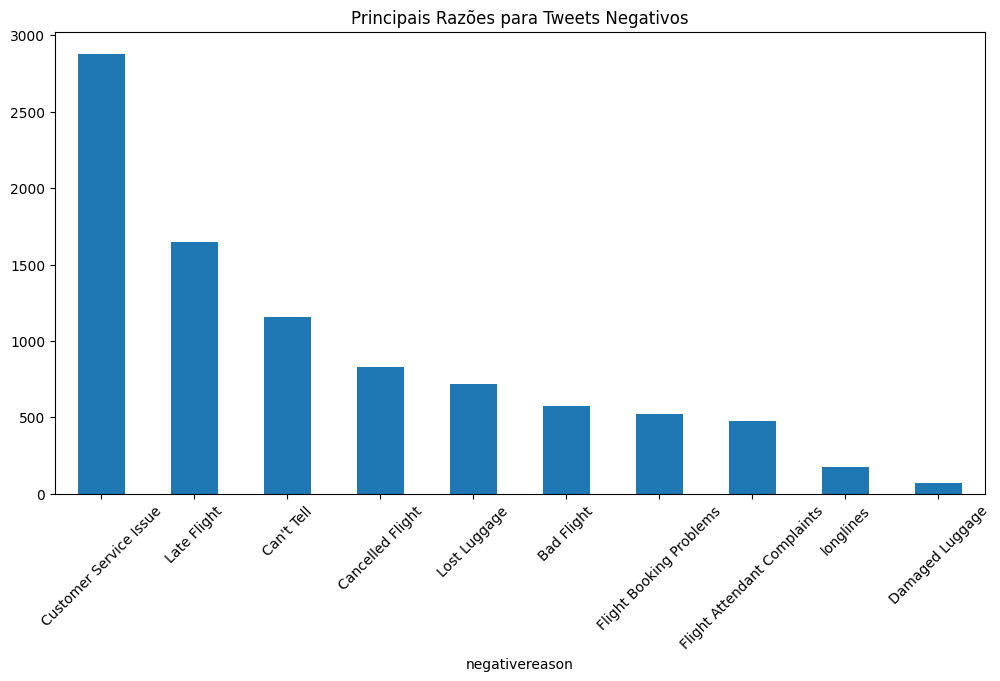

In [9]:
#Filtrando apenas os tweets negativos
negative_tweets = df[df['airline_sentiment'] == 'negative']

#Criando o Gráfico
plt.figure(figsize=(12, 6))
negative_tweets['negativereason'].value_counts().plot(kind='bar')
plt.title('Principais Razões para Tweets Negativos')
plt.xticks(rotation=45)
plt.show()

## Análise de Sentimentos

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Iniciando o analisador
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

#Aplicando a análise de sentimentos
df['sentiment_scores'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x))
df['sentiment_compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])

#Classificando com base na coluna compound score
df['vader_sentiment'] = df['sentiment_compound'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

#Comparando com as labels originais
from sklearn.metrics import classification_report
print(classification_report(df['airline_sentiment'], df['vader_sentiment']))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


              precision    recall  f1-score   support

    negative       0.90      0.51      0.65      9056
     neutral       0.38      0.42      0.40      2920
    positive       0.32      0.86      0.47      2182

    accuracy                           0.54     14158
   macro avg       0.53      0.60      0.50     14158
weighted avg       0.70      0.54      0.57     14158



#### Visualização de Polaridade ao Longo do Tempo

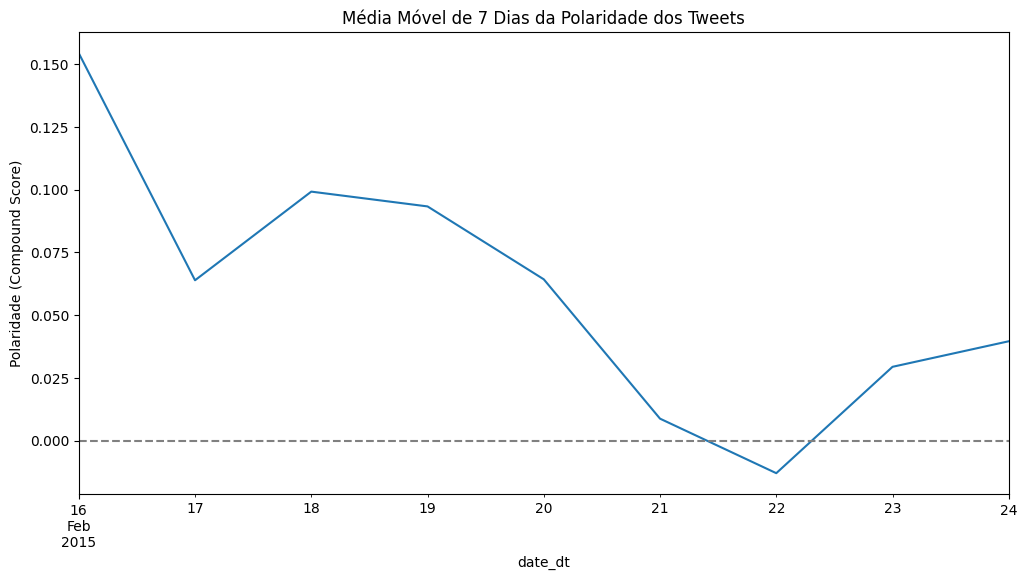

In [11]:
#Média móvel da polaridade
df['date_dt'] = pd.to_datetime(df['date'])
daily_sentiment = df.groupby('date_dt')['sentiment_compound'].mean().rolling(1).mean()

#Criando o Gráfico
plt.figure(figsize=(12, 6))
daily_sentiment.plot(title='Média Móvel de 7 Dias da Polaridade dos Tweets')
plt.ylabel('Polaridade (Compound Score)')
plt.axhline(0, color='gray', linestyle='--')
plt.show()

#### Análise de Tópicos

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Vetorização
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
X = vectorizer.fit_transform(df['processed_text'])

#Aplicando o LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

#Mostrando os tópicos
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Tópico #{topic_idx + 1}: "
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print_top_words(lda, vectorizer.get_feature_names_out(), 10)

Tópico #1: flight, cancel, flightled, get, tomorrow, weather, today, delay, home, time
Tópico #2: call, get, hold, help, hour, phone, service, back, try, wait
Tópico #3: flight, delay, hour, plane, bag, gate, wait, miss, board, get
Tópico #4: thank, customer, service, airline, fly, great, guy, send, experience, ever
Tópico #5: need, flight, get, book, seat, change, ticket, know, problem, cant


## Dashboard 

In [13]:
import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
from wordcloud import WordCloud
import io
import base64
from PIL import Image
import numpy as np


#df = pd.read_csv('Tweets.csv')

#Criando o app
app = Dash(__name__)

#Layout do dashboard
app.layout = html.Div([
    html.H1("Análise de Sentimentos de Companhias Aéreas"),
    
    html.Div([
        dcc.Graph(id='sentiment-pie'),
        dcc.Graph(id='reason-bar')
    ], style={'display': 'flex', 'width': '100%'}),
    
    html.Div([
        dcc.Graph(id='time-series'),
        html.Div(
            html.Img(id='word-cloud'),
            style={'width': '50%', 'display': 'flex', 'justify-content': 'center'}
        )
    ], style={'display': 'flex', 'width': '100%'}),
    
    dcc.Dropdown(
        id='airline-selector',
        options=[{'label': airline, 'value': airline} for airline in df['airline'].unique()],
        value=['Virgin America'],  # Valor inicial como lista
        multi=True,
        style={'width': '50%', 'margin': '20px auto'}
    )
], style={'font-family': 'Arial', 'max-width': '1200px', 'margin': '0 auto'})

#Função para gerar nuvem de palavras como imagem
def generate_wordcloud(text):
    if not text.strip():  #Se não houver texto
        #Retorna uma imagem branca vazia
        img = Image.new('RGB', (800, 400), color='white')
    else:
        wc = WordCloud(width=800, height=400, background_color='white')
        wc.generate(text)
        img = wc.to_image()
    
    buf = io.BytesIO()
    img.save(buf, format='PNG')
    buf.seek(0)
    img_str = 'data:image/png;base64,' + base64.b64encode(buf.read()).decode()
    return img_str

#Callback p
@app.callback(
    [Output('sentiment-pie', 'figure'),
     Output('reason-bar', 'figure'),
     Output('time-series', 'figure'),
     Output('word-cloud', 'src')],
    [Input('airline-selector', 'value')]
)
def update_dashboard(selected_airlines):
    #Se nenhuma companhia aérea estiver selecionada, usar todas
    if not selected_airlines:
        filtered_df = df.copy()
    else:
        filtered_df = df[df['airline'].isin(selected_airlines)]
    
    #Gráfico de pizza de sentimentos
    sentiment_counts = filtered_df['airline_sentiment'].value_counts().reset_index()
    sentiment_counts.columns = ['sentiment', 'count']
    
    sentiment_pie = px.pie(
        sentiment_counts,
        names='sentiment',
        values='count',
        title='Distribuição de Sentimentos',
        color='sentiment',
        color_discrete_map={
            'positive': '#2ca02c',
            'neutral': '#ff7f0e',
            'negative': '#d62728'
        }
    )
    sentiment_pie.update_traces(textposition='inside', textinfo='percent+label')
    
    #Gráfico de barras de razões
    reason_df = filtered_df[filtered_df['airline_sentiment'] == 'negative']
    if not reason_df.empty:
        reason_counts = reason_df['negativereason'].value_counts().reset_index()
        reason_counts.columns = ['reason', 'count']
        reason_bar = px.bar(
            reason_counts,
            x='reason',
            y='count',
            title='Principais Razões para Reclamações',
            labels={'reason': 'Razão', 'count': 'Número de Reclamações'}
        )
        reason_bar.update_layout(xaxis_tickangle=-45)
    else:
        #DataFrame vazio se não houver reclamações
        reason_bar = px.bar(title='Nenhuma reclamação encontrada')
    
    #Série temporal
    time_series_df = filtered_df.groupby('date_dt')['sentiment_compound'].mean().reset_index()
    time_series = px.line(
        time_series_df,
        x='date_dt',
        y='sentiment_compound',
        title='Sentimento Médio ao Longo do Tempo',
        labels={'date_dt': 'Data', 'sentiment_compound': 'Sentimento Médio'}
    )
    time_series.update_layout(
        yaxis_range=[-1, 1],
        shapes=[{
            'type': 'line',
            'yref': 'paper', 'y0': 0, 'y1': 1,
            'xref': 'paper', 'x0': 0, 'x1': 1,
            'line': {'color': 'gray', 'dash': 'dash'}
        }]
    )
    
    #Nuvem de palavras
    text = ' '.join(filtered_df['processed_text'].dropna().astype(str))
    wordcloud_src = generate_wordcloud(text)
    
    return sentiment_pie, reason_bar, time_series, wordcloud_src

if __name__ == '__main__':
    app.run_server(debug=True, port=8050)